# Advanced Lane Finding

## 1. Camera Calibration


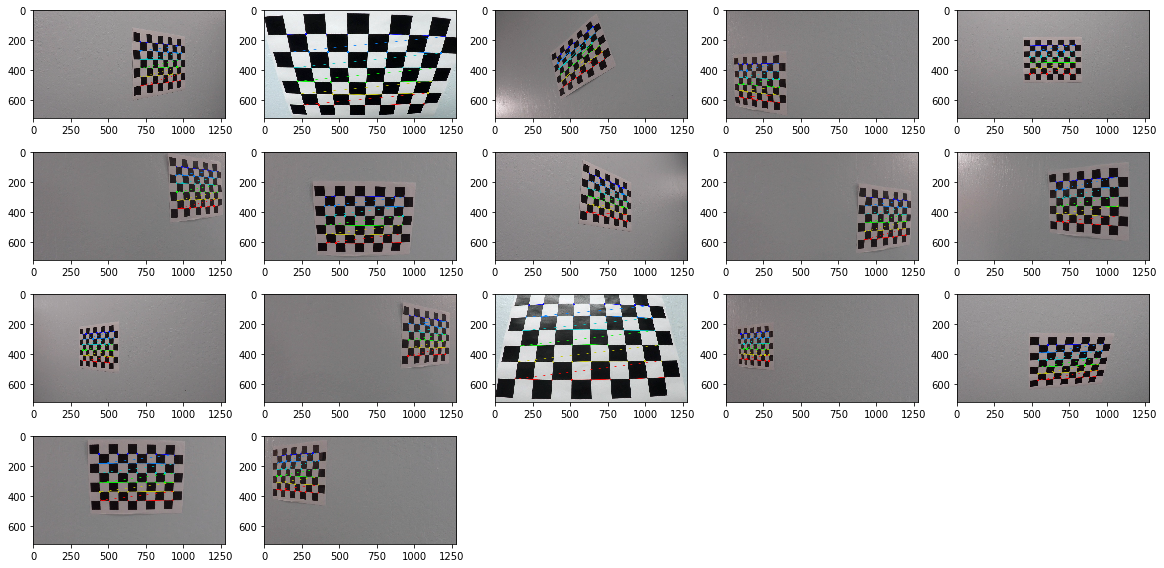

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
imlist = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        imlist.append(img)
        

plt.figure(figsize=(20,10))
columns = 5
for i, imae in enumerate(imlist):
    plt.subplot(len(imlist) / columns + 1, columns, i + 1)
    plt.imshow(imae)


# Testing Undistortion

Text(0.5,1,'Undistorted road Image')

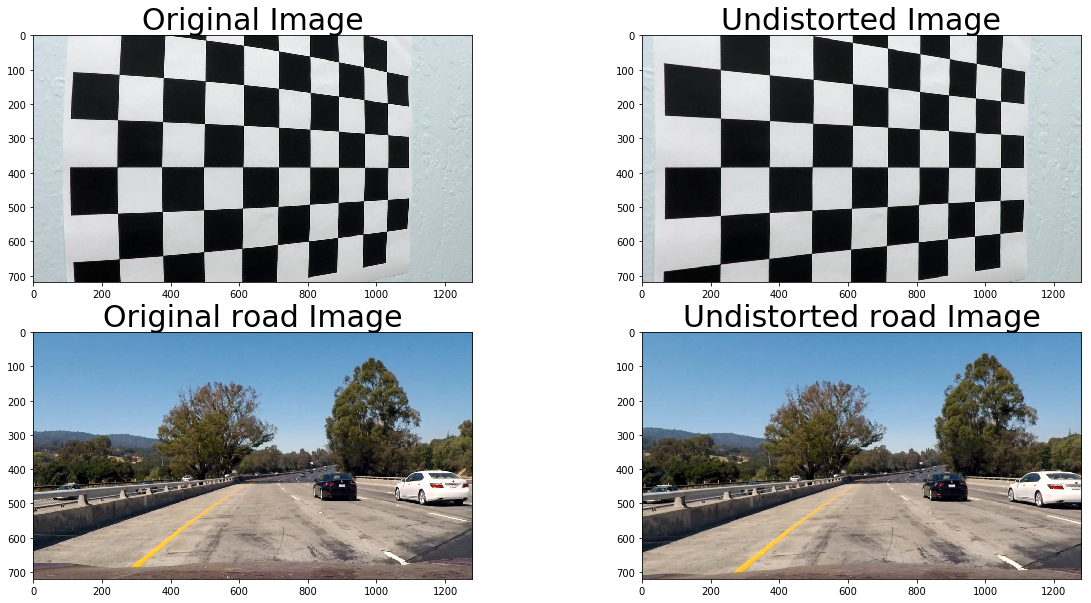

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',undist)

road = plt.imread('test_images/test1.jpg')
undist2 = cv2.undistort(road, mtx, dist, None, mtx)


# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

ax3.imshow(road)
ax3.set_title('Original road Image', fontsize=30)
ax4.imshow(undist2)
ax4.set_title('Undistorted road Image', fontsize=30)

# 2. Filter Functions

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
        thresh_min = thresh[0]
        thresh_max = thresh[1]
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in x
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        
        thresh_min = thresh[0]
        thresh_max = thresh[1]
        grad_binary = np.zeros_like(scaled_sobel)
        grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

# Testing Thresholds

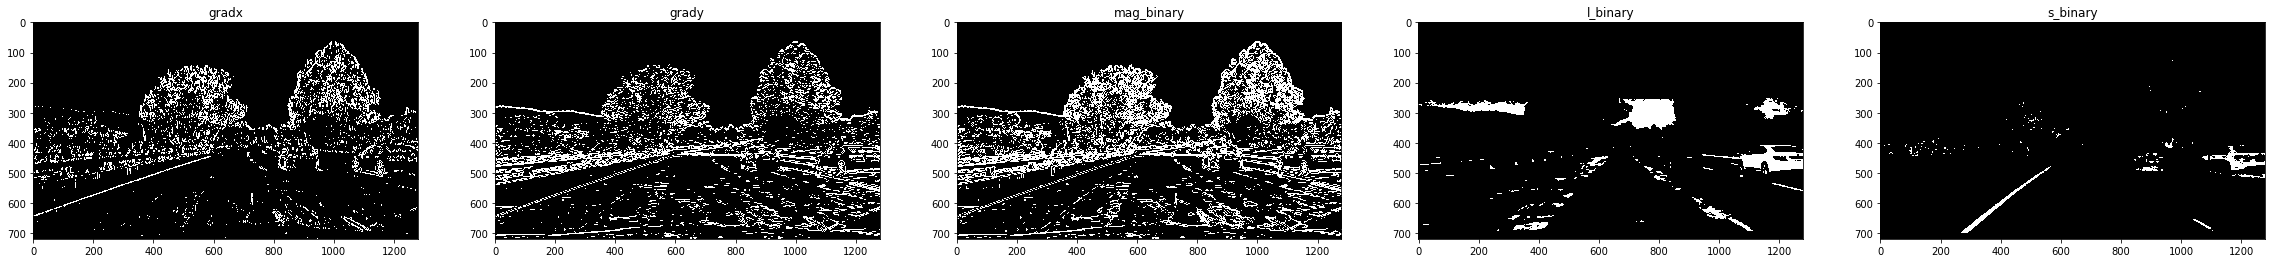

In [4]:
image = plt.imread('test_images/test1.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

blur = cv2.GaussianBlur(undist, (ksize, ksize),0)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(blur, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(blur, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(blur, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(blur, sobel_kernel=ksize, thresh=(0.5,1))

# s_channel thresholding
thresh=(170, 255)
hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
thresh_min = thresh[0]
thresh_max = thresh[1]
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
yellow_select = np.copy(image)

# l_channel thresholding
thresh=(190, 255)
hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
l_channel = hls[:,:,1]
thresh_min = thresh[0]
thresh_max = thresh[1]
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1

# Plotting thresholded images
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(40,20))
ax1.set_title('gradx')
ax1.imshow(gradx, cmap='gray')

ax2.set_title('grady')
ax2.imshow(grady, cmap='gray')

ax3.set_title('mag_binary')
ax3.imshow(mag_binary, cmap='gray')

ax4.set_title('l_binary')
ax4.imshow(l_binary, cmap='gray')

ax5.set_title('s_binary')
ax5.imshow(s_binary, cmap='gray')



# Combining Binary and Color space

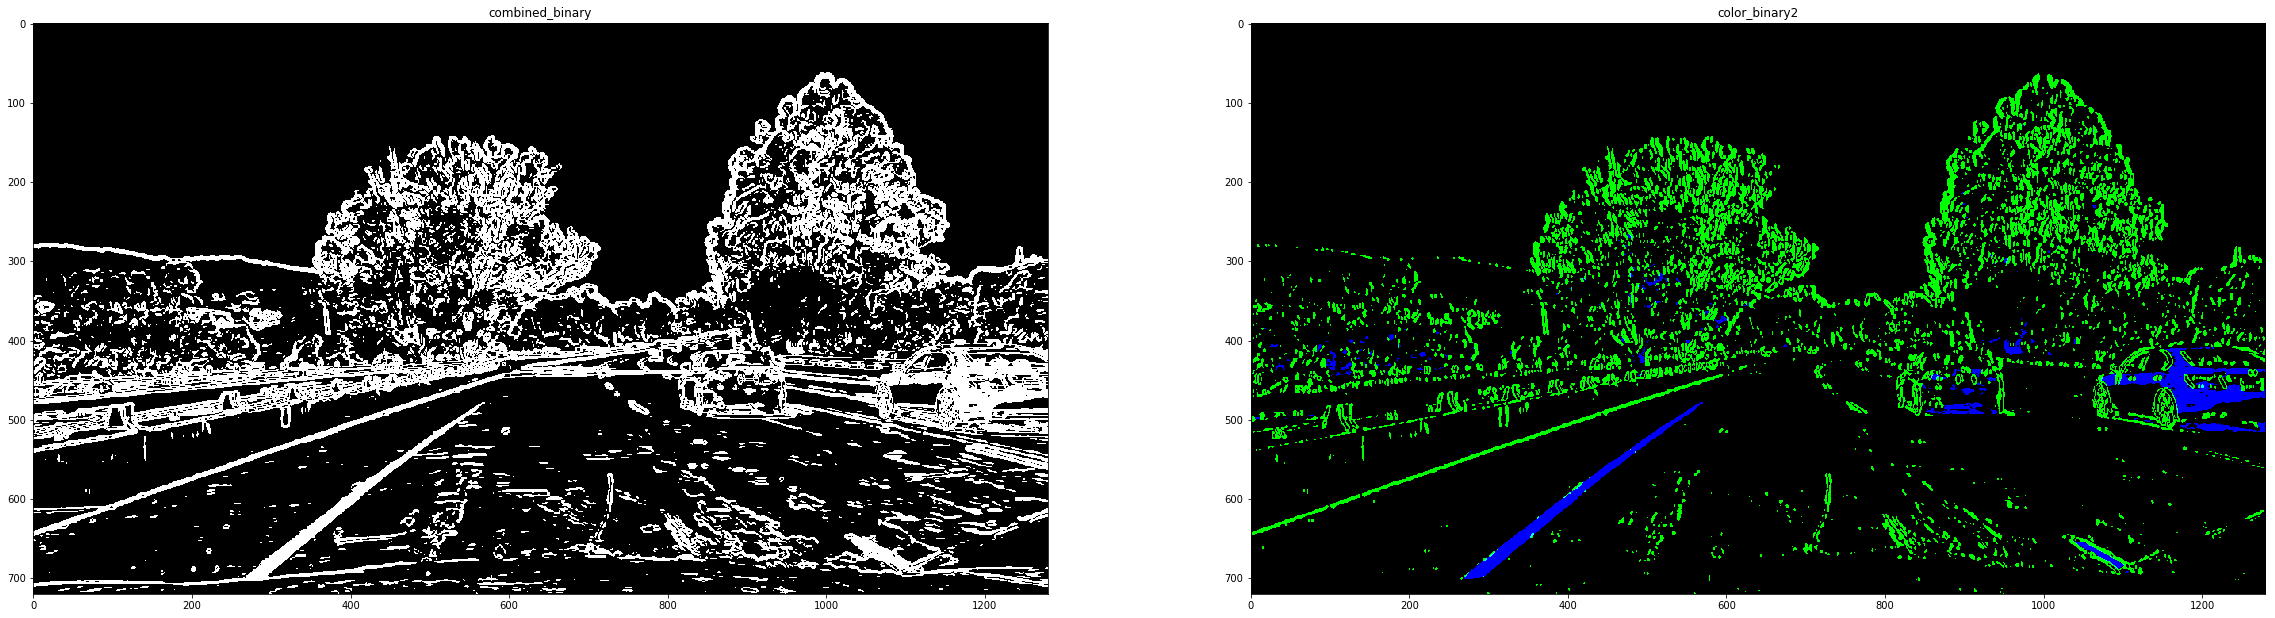

In [5]:
#combine
combined_binary = np.zeros_like(gradx)
combined_binary[(s_binary == 1) | (gradx == 1) | (grady == 1) ] = 1
    
color_binary2 = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.set_title('combined_binary')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('color_binary2')
ax2.imshow(color_binary2)


# Selected Combination

# 3. Bird's EYE view

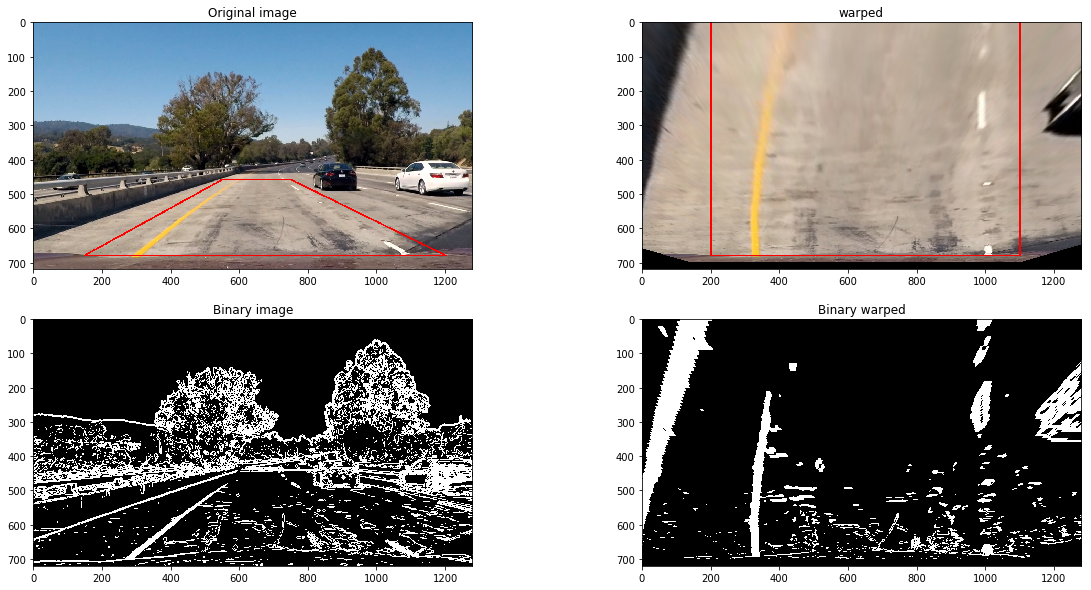

In [6]:
bird = plt.imread('test_images/test1.jpg')

imshape = image.shape
img_size = (imshape[1], imshape[0])

src = np.float32([(150,680), (550, 460), (750, 460), (1200,680)])
dst = np.float32([(200,680),(200,0),(1100,0),(1100,680)])
        
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(image, M, img_size)

cv2.polylines(image, np.int32([src]), isClosed = True, color=[255, 0, 0], thickness=3) 
cv2.polylines(warped, np.int32([dst]), isClosed = True, color=[255, 0, 0], thickness=3) 

binary_warped = cv2.warpPerspective(combined_binary, M, img_size)

f, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(image, cmap='gray')

ax2.set_title('warped')
ax2.imshow(warped)

ax3.set_title('Binary image')
ax3.imshow(combined_binary, cmap='gray')

ax4.set_title('Binary warped')
ax4.imshow(binary_warped, cmap='gray')

# 4. Detecting lane lines
## Histogram 

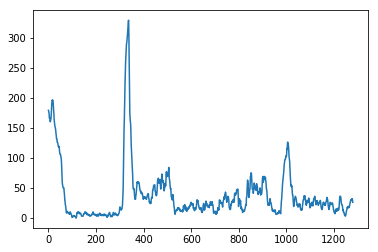

In [7]:
def hist(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)

    return histogram

# Create histogram of image binary activations
histogram = hist(binary_warped)

# Visualize the resulting histogram
plt.plot(histogram)

# Sliding Windows

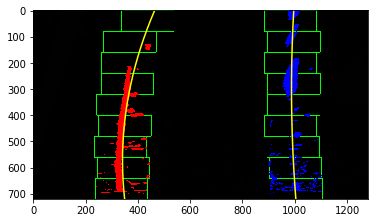

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 80

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

In [9]:
def fit_polynomialx(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

def lr_fit(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

# 5. Measuring Curvature 

In [10]:
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx, right_fitx, ploty = fit_polynomialx(binary_warped)

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # radius of curvature
    # maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty*ym_per_pix)
    
    # calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2 )**(3/2))/(np.absolute(2*left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2 )**(3/2))/(np.absolute(2*right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    left_fit, right_fit =  lr_fit(binary_warped)

    # vehicle center
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = imshape[1]/2
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    
    return int(left_curverad), int(right_curverad), center

# Testing function
left_curverad, right_curverad, center = measure_curvature_real(binary_warped)

print(left_curverad)
print(right_curverad)
print(center)


440
1739
Vehicle is 0.48m right


# 6. Overlaying Lane Area

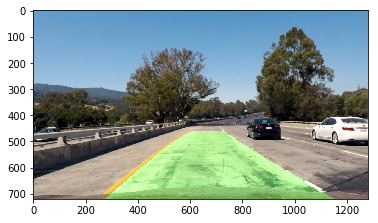

In [11]:
# Create an image to draw the lines on
fit = []
fit = fit_polynomialx(binary_warped)
left_fitx = fit[0]
right_fitx = fit[1]
ploty = fit[2]

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Drawing the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

src = np.float32([(200,680),(200,0),(1100,0),(1100,680)])
dst = np.float32([(150,680), (550, 460), (750, 460), (1200,680)])
        
Minv = cv2.getPerspectiveTransform(src, dst)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

# Pipeline

In [12]:
def process_image(image):
    
    # Removing distortion
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    blur = cv2.GaussianBlur(undist, (ksize, ksize),0)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(blur, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(blur, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(blur, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(blur, sobel_kernel=ksize, thresh=(0.7,1.3))

    # s_channel thresholding
    thresh=(160, 255)
    hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    
    # l_channel thresholding
    thresh=(185, 255)
    hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1
    
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (l_binary == 1) | ((gradx == 1) & (grady == 1))] = 1
    
    # Bird's eye
    imshape = combined_binary.shape
    img_size = (imshape[1], imshape[0])
    
    src = np.float32([(150,680), (550, 450), (750, 450), (1200,680)])
    dst = np.float32([(200,680),(200,0),(1100,0),(1100,680)])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_binary, M, img_size)

    # Draw on Image
    fit = []
    fit = fit_polynomialx(warped)
    left_fitx = fit[0]
    right_fitx = fit[1]
    ploty = fit[2]

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    src = np.float32([(200,680),(200,0),(1100,0),(1100,680)])
    dst = np.float32([(150,680), (550, 450), (750, 450), (1200,680)])
        
    Minv = cv2.getPerspectiveTransform(src, dst)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate Curve
    left_curverad, right_curverad, center = measure_curvature_real(warped)

    # describe the type of font to be used. 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # inserting text on video 
    cv2.putText(result, 'Left curvature {}'.format(left_curverad), (50, 50), font, 1, (0, 0, 0), 2, cv2.LINE_4) 
    cv2.putText(result, 'Right curvature {}'.format(right_curverad), (50, 100), font, 1, (0, 0, 0), 2, cv2.LINE_4) 
    cv2.putText(result, '{}'.format(center), (50, 150), font, 1, (0, 0, 0), 2, cv2.LINE_4) 

    return result

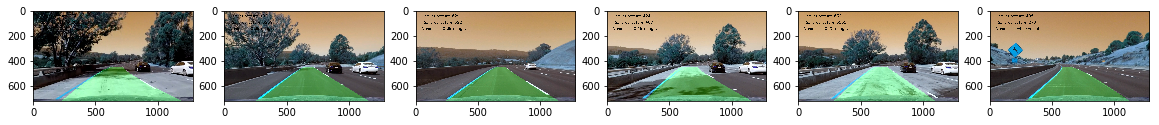

In [13]:
images = glob.glob('./test_images/test*.jpg')
imlist = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    out = process_image(img)
    imlist.append(out)
        

plt.figure(figsize=(20,10))
columns = 6
for i, imae in enumerate(imlist):
    plt.subplot(len(imlist) / columns + 1, columns, i + 1)
    plt.imshow(imae)

# Test on Video


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
output = 'output_videos/project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_processed.mp4
[MoviePy] Writing video output_videos/project_video_processed.mp4


100%|█████████▉| 1260/1261 [07:49<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_processed.mp4 

CPU times: user 4min 48s, sys: 58.9 s, total: 5min 47s
Wall time: 7min 52s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

# Working  on challenge video

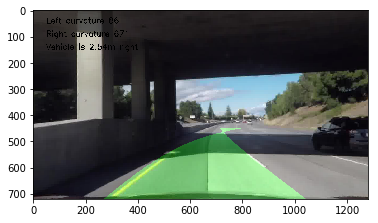

In [17]:
image = plt.imread('challenge2.jpg')

out = process_image(image)

plt.imshow(out)

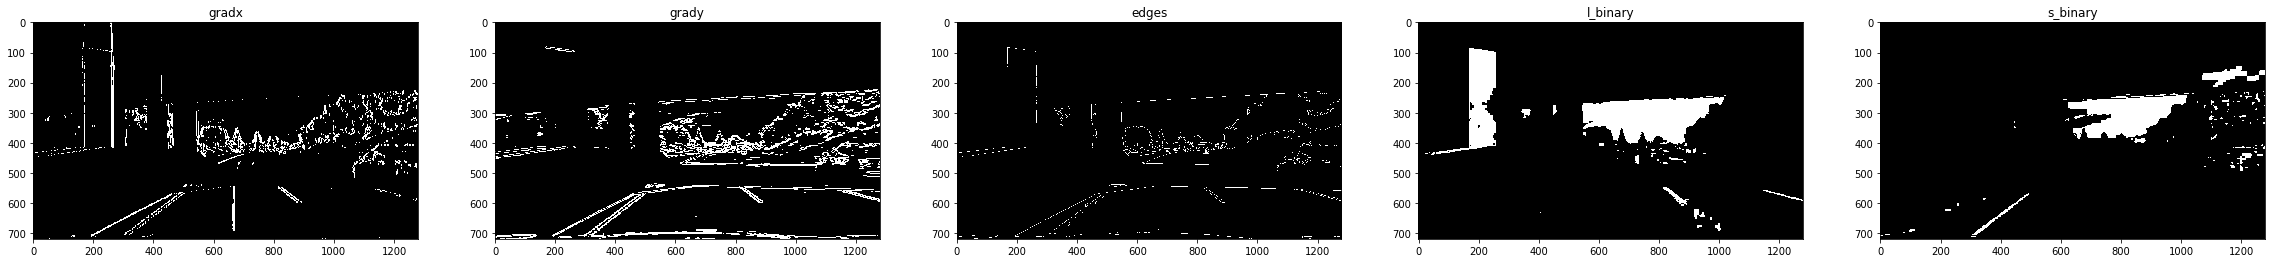

In [18]:
image = plt.imread('challenge2.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Choose a Sobel kernel size
ksize = 5 # Choose a larger odd number to smooth gradient measurements

blur = cv2.GaussianBlur(undist, (ksize, ksize),0)

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(blur, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(blur, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(blur, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(blur, sobel_kernel=ksize, thresh=(0.5,1))

# l_channel thresholding
thresh=(170, 255)
hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
l_channel = hls[:,:,1]
thresh_min = thresh[0]
thresh_max = thresh[1]
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1

# s_channel thresholding
thresh=(80, 255)
hls = cv2.cvtColor(blur, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
thresh_min = thresh[0]
thresh_max = thresh[1]
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1


# Appling Canny Edge Detection
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur, low_threshold, high_threshold)
#plt.imshow(edges, cmap='gray')

# Plotting thresholded images
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(40,20))
ax1.set_title('gradx')
ax1.imshow(gradx, cmap='gray')

ax2.set_title('grady')
ax2.imshow(grady, cmap='gray')

ax3.set_title('edges')
ax3.imshow(edges, cmap='gray')

ax4.set_title('l_binary')
ax4.imshow(l_binary, cmap='gray')

ax5.set_title('s_binary')
ax5.imshow(s_binary, cmap='gray')



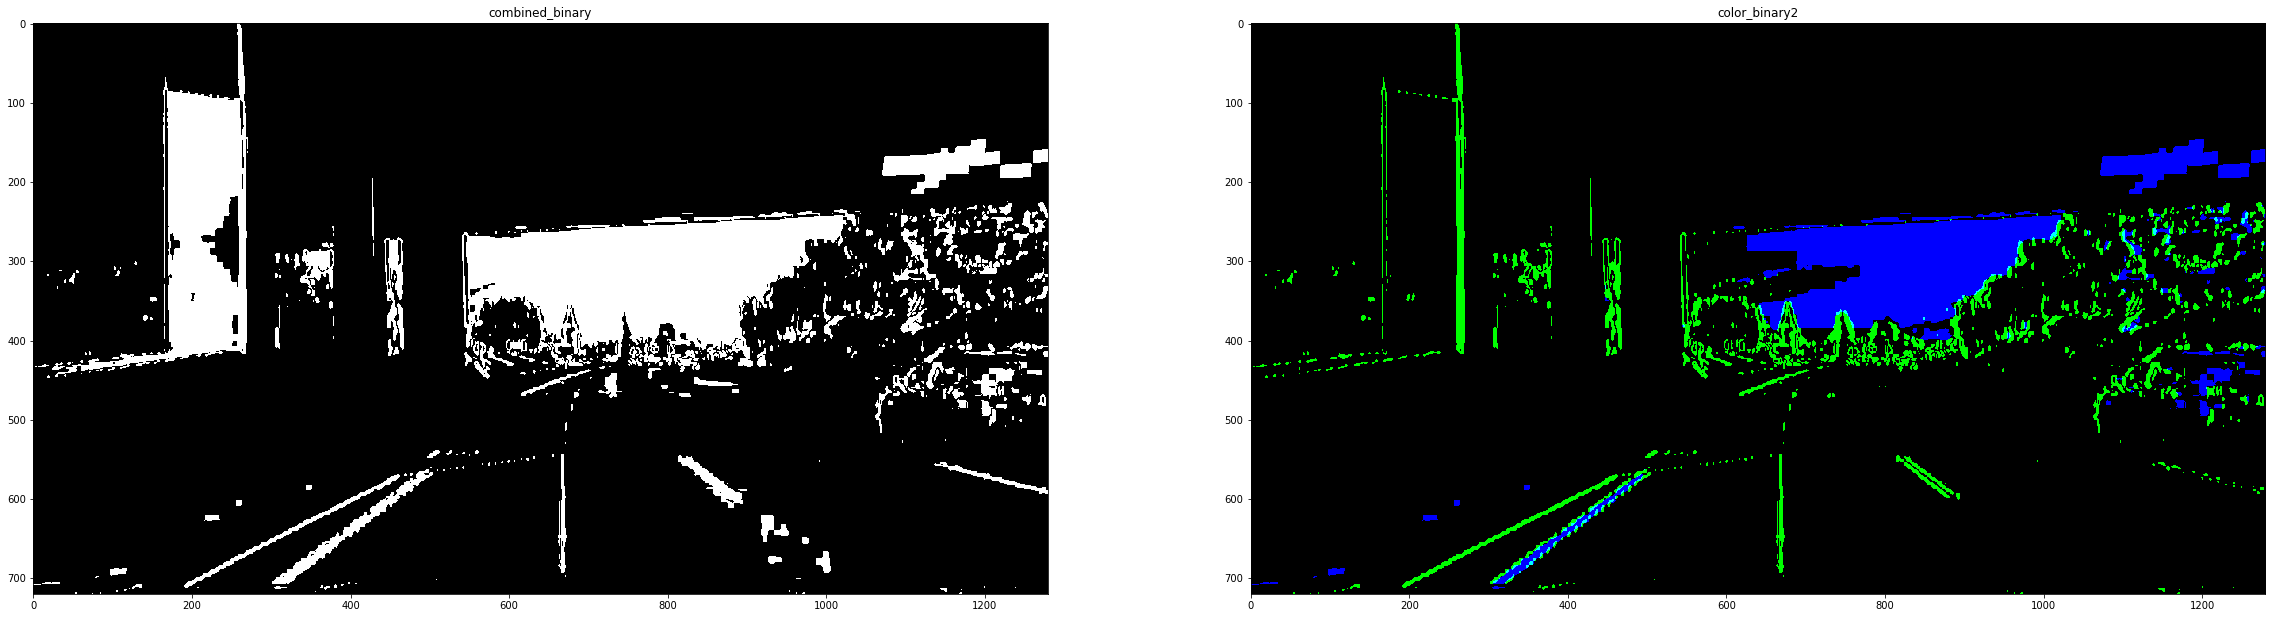

In [19]:
#combine
combined_binary = np.zeros_like(gradx)
combined_binary[(s_binary == 1) | (l_binary == 1) | (gradx == 1)] = 1
    
color_binary2 = np.dstack(( np.zeros_like(gradx), gradx, s_binary)) * 255

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
ax1.set_title('combined_binary')
ax1.imshow(combined_binary, cmap='gray')

ax2.set_title('color_binary2')
ax2.imshow(color_binary2)


In [20]:
def process_image2(image):
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))

    # l_channel thresholding
    thresh=(160, 255)
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1
    
    # s_channel thresholding
    thresh=(80, 255)
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (l_binary == 1) | (gradx == 1)] = 1
    
    # Bird's eye
    imshape = combined_binary.shape
    img_size = (imshape[1], imshape[0])


    src = np.float32([(150,700), (650, 450), (750, 450), (1200,700)])
    dst = np.float32([(150,700),(550,0),(imshape[1],0),(1200,700)])
        

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_binary, M, img_size)

    # Draw on Image
    fit = []
    fit = fit_polynomialx(warped)
    left_fitx = fit[0]
    right_fitx = fit[1]
    ploty = fit[2]


    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    dst = np.float32([(150,700), (650, 450), (750, 450), (1200,700)])
    src = np.float32([(150,700),(550,0),(imshape[1],0),(1200,700)])
        
    Minv = cv2.getPerspectiveTransform(src, dst)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate Curve
    left_curverad, right_curverad, center = measure_curvature_real(warped)

    # describe the type of font to be used. 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # inserting text on video 
    cv2.putText(result, 'Left curvature {}'.format(left_curverad), (50, 50), font, 1, (0, 0, 0), 2, cv2.LINE_4) 
    cv2.putText(result, 'Right curvature {}'.format(right_curverad), (50, 100), font, 1, (0, 0, 0), 2, cv2.LINE_4) 
    cv2.putText(result, '{}'.format(center), (50, 150), font, 1, (0, 0, 0), 2, cv2.LINE_4) 

    return result

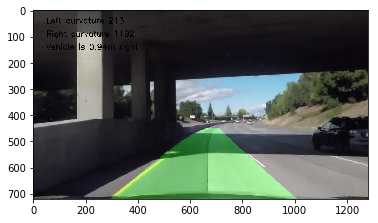

In [21]:
image = plt.imread('challenge2.jpg')

out = process_image2(image)

plt.imshow(out)

In [22]:
output2 = 'output_videos/challenge_video_processed.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_processed.mp4
[MoviePy] Writing video output_videos/challenge_video_processed.mp4


100%|██████████| 485/485 [02:30<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_processed.mp4 

CPU times: user 1min 45s, sys: 1.27 s, total: 1min 47s
Wall time: 2min 33s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [24]:
output3 = 'output_videos/harder_challenge_video_processed.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image2)
%time white_clip.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_processed.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_processed.mp4


100%|█████████▉| 1199/1200 [07:10<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_processed.mp4 

CPU times: user 4min 32s, sys: 5.63 s, total: 4min 38s
Wall time: 7min 14s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))

# Trying another color space "LAB"

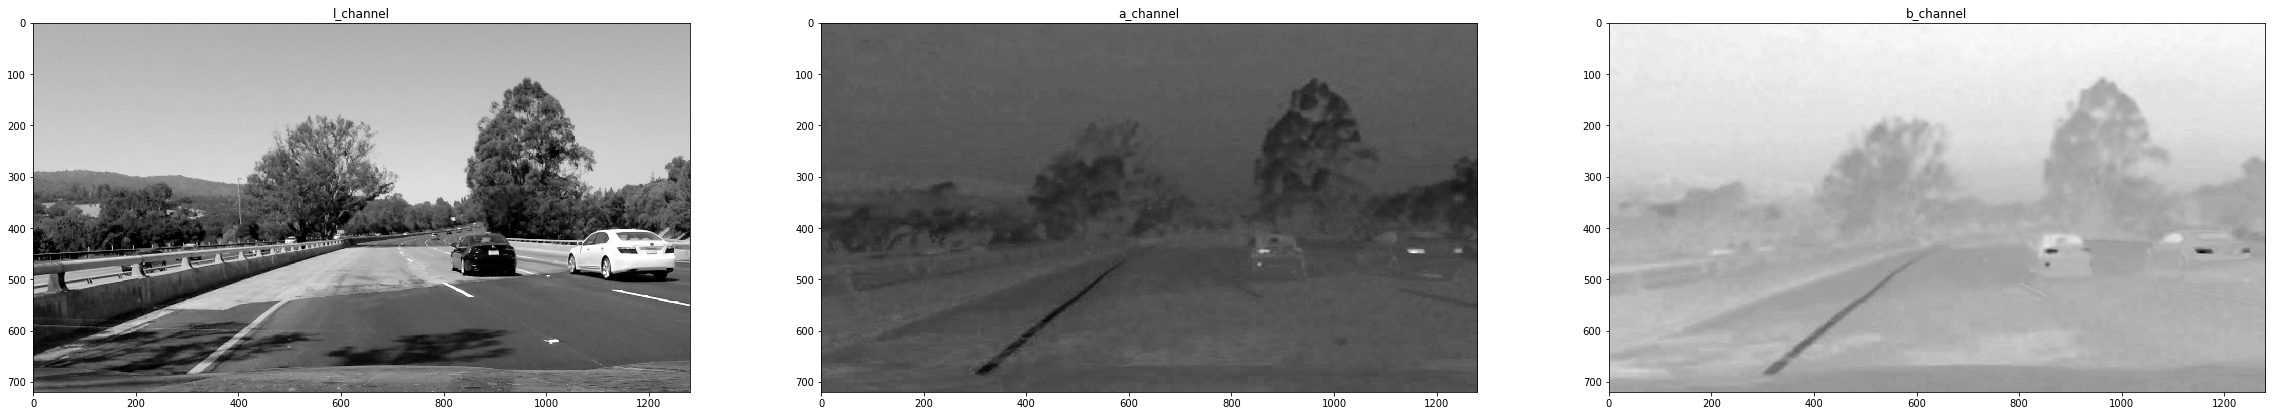

In [26]:
test = plt.imread('test_images/test4.jpg')

lab = cv2.cvtColor(test, cv2.COLOR_BGR2LAB)
l_channel = lab[:,:,0]
a_channel = lab[:,:,1]
b_channel = lab[:,:,2]

# Plotting channel images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,20))
ax1.set_title('l_channel')
ax1.imshow(l_channel, cmap='gray')

ax2.set_title('a_channel')
ax2.imshow(a_channel, cmap='gray')


ax3.set_title('b_channel')
ax3.imshow(b_channel, cmap='gray')


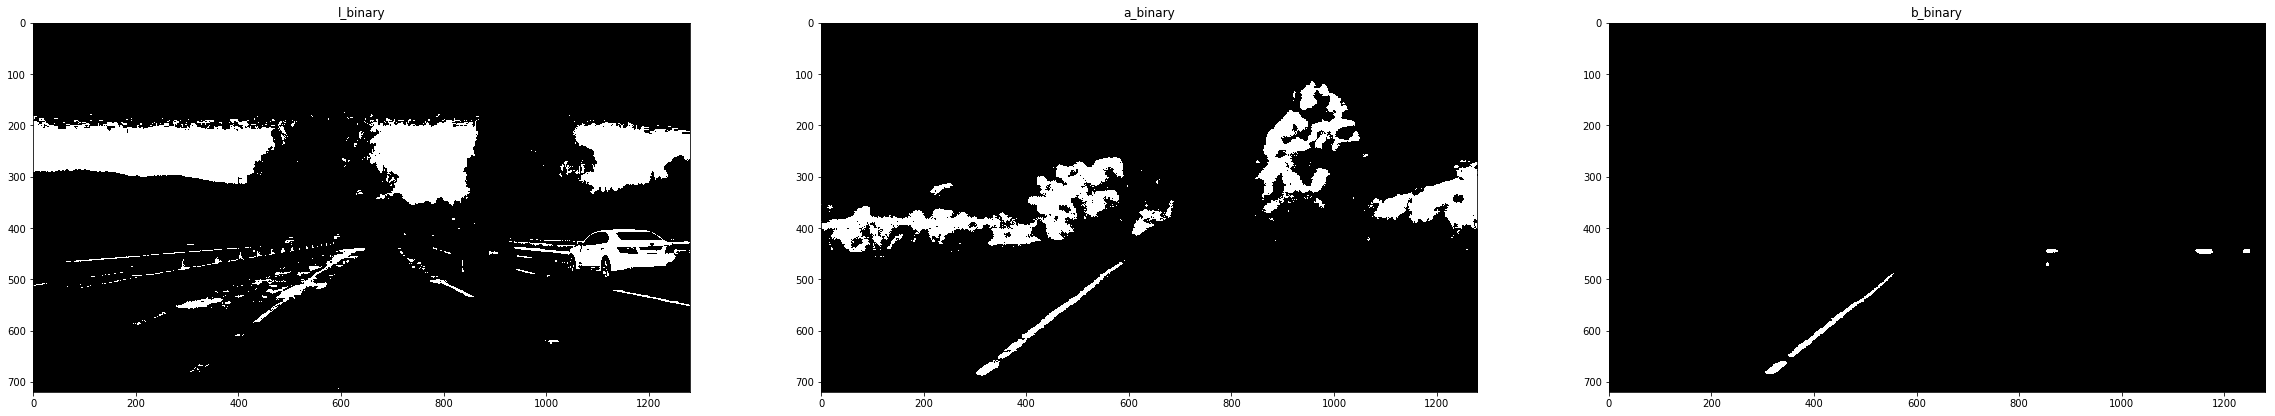

In [27]:
thresh=(200, 255)
thresh_min = thresh[0]
thresh_max = thresh[1]
l_binary = np.zeros_like(l_channel)
l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1

thresh=(0, 120)
thresh_min = thresh[0]
thresh_max = thresh[1]
a_binary = np.zeros_like(a_channel)
a_binary[(a_channel >= thresh_min) & (a_channel <= thresh_max)] = 1

thresh=(20, 100)
thresh_min = thresh[0]
thresh_max = thresh[1]
b_binary = np.zeros_like(b_channel)
b_binary[(b_channel >= thresh_min) & (b_channel <= thresh_max)] = 1

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,20))
ax1.set_title('l_binary')
ax1.imshow(l_binary, cmap='gray')

ax2.set_title('a_binary')
ax2.imshow(a_binary, cmap='gray')

ax3.set_title('b_binary')
ax3.imshow(b_binary, cmap='gray')

In [28]:
def process_image3(image):
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))

    # l_channel thresholding
    thresh=(160, 255)
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= thresh_min) & (l_channel <= thresh_max)] = 1
    
    # s_channel thresholding
    thresh=(80, 255)
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    
    # LAB thresholding
    lab = cv2.cvtColor(undist, cv2.COLOR_BGR2LAB)
    la_channel = lab[:,:,0]
    a_channel = lab[:,:,1]
    b_channel = lab[:,:,2]

    # L_channel thresholding    
    thresh=(200, 255)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    la_binary = np.zeros_like(la_channel)
    la_binary[(la_channel >= thresh_min) & (la_channel <= thresh_max)] = 1

    # a_channel thresholding
    thresh=(0, 120)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    a_binary = np.zeros_like(a_channel)
    a_binary[(a_channel >= thresh_min) & (a_channel <= thresh_max)] = 1

    # b_channel thresholding
    thresh=(20, 100)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh_min) & (b_channel <= thresh_max)] = 1
    
    #combining
    combined_binary = np.zeros_like(gradx)
    combined_binary[(s_binary == 1) | (la_binary == 1) | (a_binary == 1) | (b_binary == 1) | (gradx == 1)] = 1
    
    # Bird's eye
    imshape = combined_binary.shape
    img_size = (imshape[1], imshape[0])

    src = np.float32([(150,700), (650, 450), (750, 450), (1200,700)])
    dst = np.float32([(150,700),(550,0),(imshape[1],0),(1200,700)])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(combined_binary, M, img_size)

    # Draw on Image
    fit = []
    fit = fit_polynomialx(warped)
    left_fitx = fit[0]
    right_fitx = fit[1]
    ploty = fit[2]

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    dst = np.float32([(150,700), (650, 450), (750, 450), (1200,700)])
    src = np.float32([(150,700),(550,0),(imshape[1],0),(1200,700)])
        
    Minv = cv2.getPerspectiveTransform(src, dst)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Calculate Curve
    left_curverad, right_curverad, center = measure_curvature_real(warped)

    # describe the type of font to be used. 
    font = cv2.FONT_HERSHEY_SIMPLEX 
  
    # inserting text on video 
    cv2.putText(result, 'Left curvature {}'.format(left_curverad), (50, 50), font, 1, (0, 0, 0), 2, cv2.LINE_4) 
    cv2.putText(result, 'Right curvature {}'.format(right_curverad), (50, 100), font, 1, (0, 0, 0), 2, cv2.LINE_4) 
    cv2.putText(result, '{}'.format(center), (50, 150), font, 1, (0, 0, 0), 2, cv2.LINE_4) 

    return result

In [29]:
output4 = 'output_videos/project_video_processed2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image3)
%time white_clip.write_videofile(output4, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_processed2.mp4
[MoviePy] Writing video output_videos/project_video_processed2.mp4


100%|█████████▉| 1260/1261 [05:10<00:00,  4.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_processed2.mp4 

CPU times: user 3min 6s, sys: 3.16 s, total: 3min 9s
Wall time: 5min 13s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output4))

In [31]:
output5 = 'output_videos/challenge_video_processed2.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image3)
%time white_clip.write_videofile(output5, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video_processed2.mp4
[MoviePy] Writing video output_videos/challenge_video_processed2.mp4


100%|██████████| 485/485 [01:48<00:00,  4.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_processed2.mp4 

CPU times: user 1min 4s, sys: 1.14 s, total: 1min 5s
Wall time: 1min 51s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output5))